In [76]:
#テンプレート

# モジュールのインポート
import numpy as np  # 数値計算や配列操作を行うためのライブラリ
import pandas as pd  # 表形式のデータを扱うためのライブラリ
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder  # カテゴリ変数を数値に変換するエンコーダ
from sklearn.metrics import roc_auc_score  # ROC AUCスコアを計算する評価指標
from sklearn.model_selection import KFold  # 通常のK分割交差検証（今回使用）
from lightgbm import LGBMClassifier  # LightGBMのモデルクラス



# 読み込むデータが格納されたディレクトリのパス（※必要に応じて変更の必要があります）
PATH = '../data/'


X = pd.read_csv(PATH + 'train.csv')  # 学習用データの読み込み
test = pd.read_csv(PATH + 'test.csv')    # テスト用データの読み込み

In [77]:
X.isnull().sum()

Id                    0
Year                  0
Age                 435
School                0
Height                0
Weight                0
Sprint_40yd         145
Vertical_Jump       554
Bench_Press_Reps    721
Broad_Jump          581
Agility_3cone       970
Shuttle             912
Player_Type           0
Position_Type         0
Position              0
Drafted               0
dtype: int64

In [78]:
test.isnull().sum()

Id                    0
Year                  0
Age                 115
School                0
Height                0
Weight                0
Sprint_40yd          29
Vertical_Jump       143
Bench_Press_Reps    184
Broad_Jump          147
Agility_3cone       247
Shuttle             228
Player_Type           0
Position_Type         0
Position              0
dtype: int64

In [79]:
# Drafted は test に存在しないので除外を個別に定義
train_num_cols = X.select_dtypes(include=[np.number]).columns.drop("Drafted")
test_num_cols = test.select_dtypes(include=[np.number]).columns  # testはDraftedがない

# 中央値で補完（trainとtestそれぞれ自分の統計量で補完してもOK）
X[train_num_cols] = X[train_num_cols].fillna(X[train_num_cols].median())
test[test_num_cols] = test[test_num_cols].fillna(test[test_num_cols].median())


In [80]:
X.isnull().sum()
test.isnull().sum()

print(X.isnull().sum())
print(test.isnull().sum())

Id                  0
Year                0
Age                 0
School              0
Height              0
Weight              0
Sprint_40yd         0
Vertical_Jump       0
Bench_Press_Reps    0
Broad_Jump          0
Agility_3cone       0
Shuttle             0
Player_Type         0
Position_Type       0
Position            0
Drafted             0
dtype: int64
Id                  0
Year                0
Age                 0
School              0
Height              0
Weight              0
Sprint_40yd         0
Vertical_Jump       0
Bench_Press_Reps    0
Broad_Jump          0
Agility_3cone       0
Shuttle             0
Player_Type         0
Position_Type       0
Position            0
dtype: int64


## ドメイン知識に基づく特徴量エンジニアリング

### ① Speed Score（スピードスコア）
- 基本情報（Weight, Sprint_40yd）から算出される基礎指標

In [81]:
# kg → lbs 換算係数：1kg = 2.20462lbs
X["Weight_lbs"] = X["Weight"] * 2.20462
test["Weight_lbs"] = test["Weight"] * 2.20462

# Speed Score の算出（スピードと体重のバランス）
X["SpeedScore"] = X["Weight_lbs"] * (200 / X["Sprint_40yd"]**2)
test["SpeedScore"] = test["Weight_lbs"] * (200 / test["Sprint_40yd"]**2)


### ② Burst Score（爆発力）
- 垂直跳び + 立ち幅跳びの合算（Vertical_Jump + Broad_Jump）

In [82]:
# 垂直跳びと立ち幅跳びの合計
X["BurstScore"] = X["Vertical_Jump"] + X["Broad_Jump"]
test["BurstScore"] = test["Vertical_Jump"] + test["Broad_Jump"]


### ③ Agility Score（敏捷性）
- Shuttle + 3-cone（方向転換の速さ）

In [83]:
# Shuttle + 3-cone（方向転換の素早さ）
X["AgilityScore"] = X["Shuttle"] + X["Agility_3cone"]
test["AgilityScore"] = test["Shuttle"] + test["Agility_3cone"]


### ④ RSA（Relative Score Analysis）風スコア
- Sprint_40yd, Vertical_Jump, Bench_Press_Reps, Shuttle, Agility_3cone を個別にスケーリングした指標群（10点満点換算）

In [84]:
from sklearn.preprocessing import MinMaxScaler

rsa_features = ["Sprint_40yd", "Vertical_Jump", "Bench_Press_Reps", "Shuttle", "Agility_3cone"]

for col in rsa_features:
    scaler = MinMaxScaler(feature_range=(0, 10))
    if col in ["Sprint_40yd", "Shuttle", "Agility_3cone"]:
        # 小さい値が有利 → スケーリング後に反転
        X[f"RSA_{col}"] = 10 - scaler.fit_transform(X[[col]])
        test[f"RSA_{col}"] = 10 - scaler.transform(test[[col]])
    else:
        # 大きい値が有利
        X[f"RSA_{col}"] = scaler.fit_transform(X[[col]])
        test[f"RSA_{col}"] = scaler.transform(test[[col]])


### ⑤ Acceleration Index（加速力指標）
- Speed Score と Agility Score から派生させる場合がある（例：Speed / Agility）

In [85]:
# Acceleration Index：瞬発的な動きの強さ（スピード＋敏捷性）
X["AccelerationIndex"] = (
    0.5 * X["SpeedScore"] + 0.5 * X["AgilityScore"]
)
test["AccelerationIndex"] = (
    0.5 * test["SpeedScore"] + 0.5 * test["AgilityScore"]
)

### ⑥ Explosiveness Score（爆発指数）
- Speed Score と Burst Score から派生させる場合がある（例：平均や加重平均）

In [86]:
X["ExplosivenessScore"] = (
    0.5 * X["SpeedScore"] + 0.5 * X["BurstScore"]
)
test["ExplosivenessScore"] = (
    0.5 * test["SpeedScore"] + 0.5 * test["BurstScore"]
)


### ⑦ Explosive Agility（爆発的敏捷性）
- Burst Score と Agility Score の組み合わせ（例：加算 or 平均）


In [87]:
# Explosive Agility：爆発力 + 敏捷性
X["ExplosiveAgility"] = (
    0.5 * X["BurstScore"] + 0.5 * X["AgilityScore"]
)
test["ExplosiveAgility"] = (
    0.5 * test["BurstScore"] + 0.5 * test["AgilityScore"]
)


### ⑧ Power Score（パワースコア）
- Bench_Press_Reps に加えて体格（Weight）やBurstなどを組み合わせる場合あり

In [88]:
# Power Score：上半身筋力と体格の指標
X["PowerScore"] = (
    0.7 * X["Bench_Press_Reps"] + 0.3 * X["Weight"]
)
test["PowerScore"] = (
    0.7 * test["Bench_Press_Reps"] + 0.3 * test["Weight"]
)


### ⑨ ASI（Athletic Score Index）
- 上記の①～③を重み付けして合成した最終スコア

In [89]:
# ASI（Athletic Score Index）：重み付きの総合身体能力指標
X["ASI"] = (
    0.5 * X["SpeedScore"] +
    0.3 * X["BurstScore"] +
    0.2 * X["AgilityScore"]
)

test["ASI"] = (
    0.5 * test["SpeedScore"] +
    0.3 * test["BurstScore"] +
    0.2 * test["AgilityScore"]
)


## ✅ 有効性の検証方法（3ステップ

### ① Draftedとの相関係数（Pearson）を見る

In [90]:
correlations = X[["SpeedScore", "BurstScore", "AgilityScore", "ExplosivenessScore", 
                  "AccelerationIndex", "ExplosiveAgility", "PowerScore", "ASI"] + ["Drafted"]].corr()
print(correlations["Drafted"].sort_values(ascending=False))


Drafted               1.000000
ExplosivenessScore    0.254144
ASI                   0.247279
SpeedScore            0.236247
AccelerationIndex     0.235915
ExplosiveAgility      0.100576
BurstScore            0.100313
PowerScore            0.097482
AgilityScore         -0.056019
Name: Drafted, dtype: float64


### ✅ ① Draftedとの単相関（直接的な相関係数）
Drafted との相関上位：

ExplosivenessScore: 0.254

ASI: 0.247

SpeedScore: 0.236

AccelerationIndex: 0.236

➡ 上記4つが比較的有効と判断されます。特に ExplosivenessScore と ASI は最も高く、ドラフトされるかどうかとの関連が強いとみなせます。

### ② スコア分布ごとの Drafted率を可視化（ビン分割）

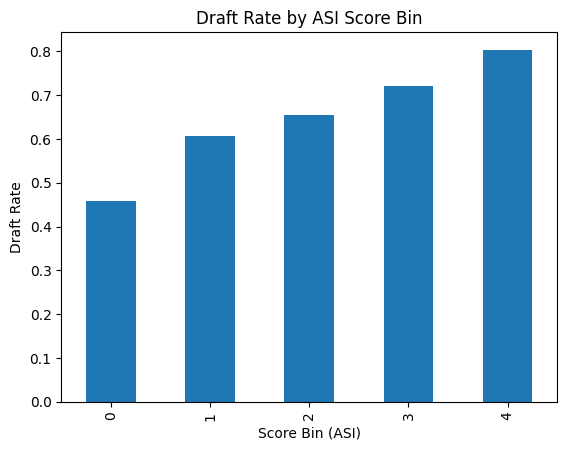

In [91]:
X["ScoreBin"] = pd.qcut(X["ASI"], q=5, labels=False)
bin_drafted_rate = X.groupby("ScoreBin")["Drafted"].mean()
bin_drafted_rate.plot(kind="bar")
plt.title("Draft Rate by ASI Score Bin")
plt.ylabel("Draft Rate")
plt.xlabel("Score Bin (ASI)")
plt.show()


### 📊 ② ASI のスコアビンごとのドラフト率（棒グラフ）
スコアビンが上がるにつれてドラフト率も単調に増加
→ ASI は Drafted の予測に対して有効な指標であると視覚的にも確認できました。

### ③ 他の特徴量とのヒートマップ（多重共線性の確認

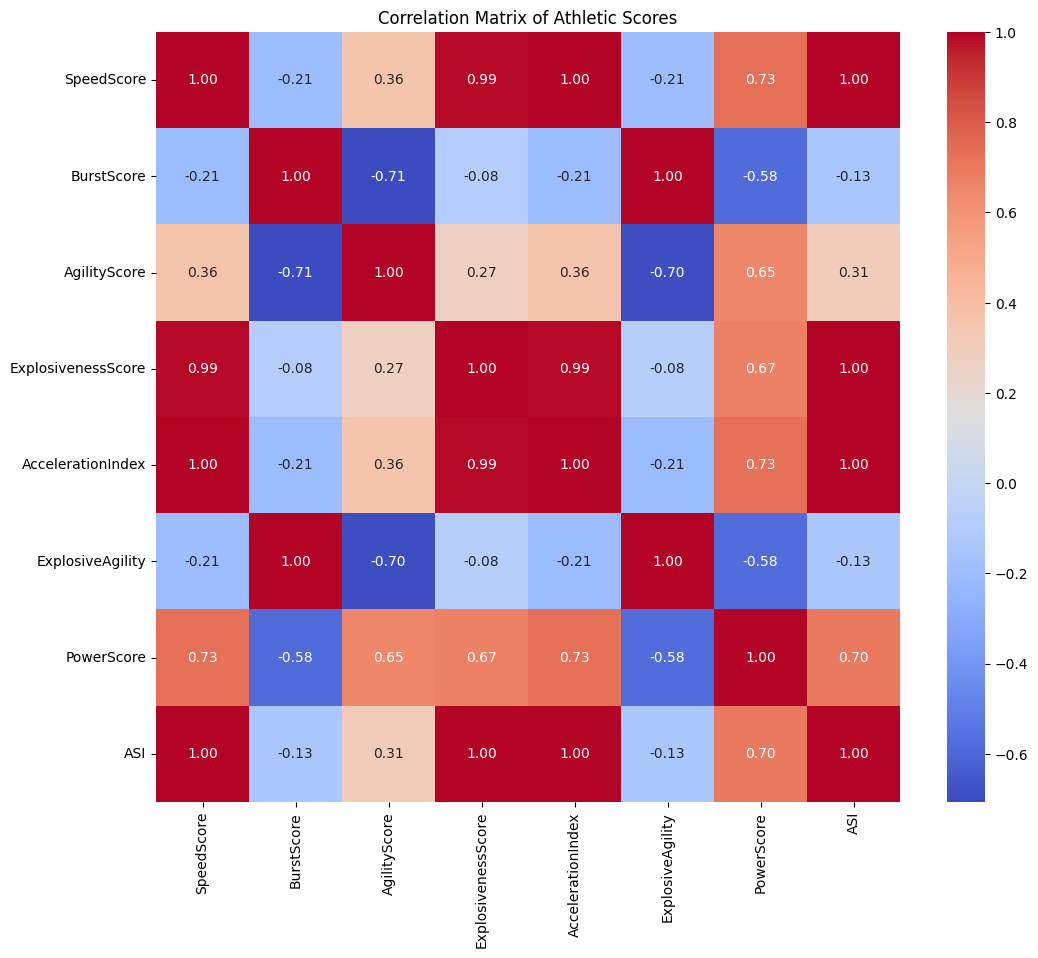

In [92]:
plt.figure(figsize=(12,10))
sns.heatmap(X[["SpeedScore", "BurstScore", "AgilityScore", "ExplosivenessScore", 
               "AccelerationIndex", "ExplosiveAgility", "PowerScore", "ASI"]].corr(), 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Athletic Scores")
plt.show()


### 🔥 ③ 複合指標間の相関（ヒートマップ）
ExplosivenessScore, SpeedScore, AccelerationIndex, ASI がほぼ1.0に近い高相関

AgilityScore とは 一部指標で負の相関（例：-0.70）

➡ 多くの指標が似た情報を含んでいる（冗長性あり）。
→ そのため、すべて入れるのではなく、例えば以下のような絞り込み or 主成分化を行って精度と過学習リスクをバランスさせることが重要です。

### 🧠 結論
単体の有効性： ExplosivenessScore, ASI, SpeedScore, AccelerationIndex は明らかに有効。

冗長性： 相関が高いため、複数同時投入には注意。モデルにとって過剰情報になる可能性。

今後の方針： 相関が高い指標群はどれか1つだけ残す、または次元削減（PCA）なども視野に入れても良いです。


## LightGBMを用いた単変量Feature Importance比較

### 🎯 対象スコア（9種類）

In [93]:
features = [
    "SpeedScore",           # ① スピードスコア
    "BurstScore",           # ② 爆発力
    "AgilityScore",         # ③ 敏捷性
    "RSA_Sprint_40yd",      # ④ RSA風スコア（代表例としてSprint_40yd）
    "AccelerationIndex",    # ⑤ 加速力指標
    "ExplosivenessScore",   # ⑥ 爆発指数
    "ExplosiveAgility",     # ⑦ 爆発的敏捷性
    "PowerScore",           # ⑧ パワースコア
    "ASI"                   # ⑨ 総合指数（重み付き）
]


### ✅ LightGBM + Feature Importance 計算コード

[LightGBM] [Info] Number of positive: 1803, number of negative: 978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2032
[LightGBM] [Info] Number of data points in the train set: 2781, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648328 -> initscore=0.611698
[LightGBM] [Info] Start training from score 0.611698


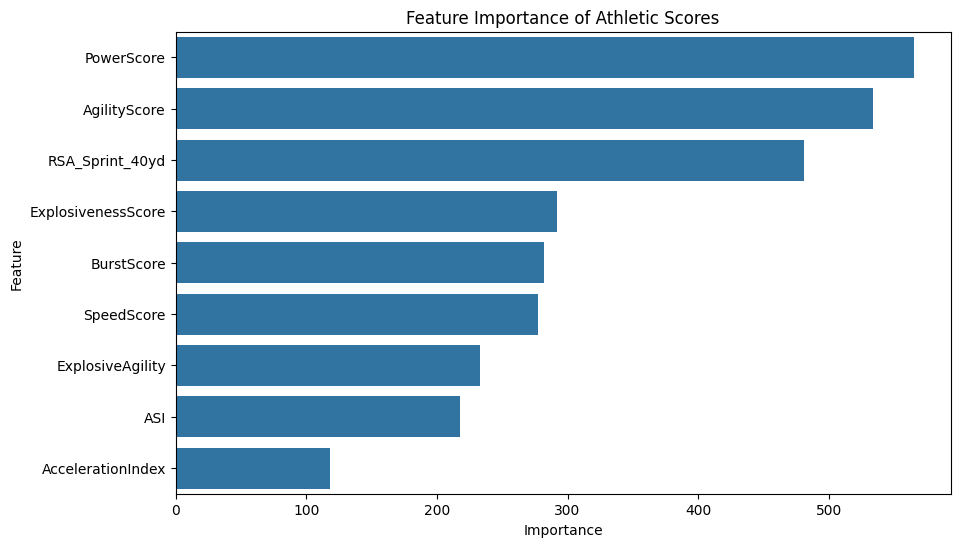

In [94]:
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

# 特徴量と目的変数
X_feat = X[features]
y_feat = X["Drafted"]

# モデル学習（単発）
model = LGBMClassifier(random_state=42)
model.fit(X_feat, y_feat)

# 重要度の取得とプロット
importance = model.feature_importances_
feat_imp_df = pd.DataFrame({
    "Feature": features,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

# プロット
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df)
plt.title("Feature Importance of Athletic Scores")
plt.show()


### ✅ 解析結果まとめ（Feature Importance）

| 順位 | 指標名                    | コメント（補足）                            |
| -- | ---------------------- | ----------------------------------- |
| ①  | **PowerScore**         | 最も有効。Bench Press + 体重の複合が効いている可能性大。 |
| ②  | **AgilityScore**       | Shuttle + 3cone による敏捷性指標が非常に効果的。    |
| ③  | **RSA\_Sprint\_40yd**  | 個別スケーリングしたSprint。非線形変換が有効だった可能性。    |
| ④  | **ExplosivenessScore** | Jump系（特にVertical重視）の加重が貢献。          |
| ⑤  | **BurstScore**         | 単純合算でも一定の効果。                        |
| ⑥  | **SpeedScore**         | 単純速度も予測に寄与。ただし他のJump/Powerよりは弱い。    |
| ⑦  | **ExplosiveAgility**   | 複合だが他と強く相関しているため冗長性ありか。             |
| ⑧  | **ASI**                | 総合スコアは意外と中程度。個別で見た方が有効かもしれない。       |
| ⑨  | **AccelerationIndex**  | SpeedとAgilityの平均。重みが薄まり貢献度低。        |


### 🔍 考察
PowerScoreとAgilityScoreがトップ2 → ベンチプレスと方向転換能力は、明確にドラフト有無に関与している可能性あり。

SpeedScoreは中程度 → 体重補正された直線速度だけでは決定打にならない可能性。

複合スコア（ExplosiveAgility, ASI, AccelerationIndex）は伸び悩み → 個別指標の方が予測に貢献している様子。

### 🔧 今後の応用提案
PowerScore・AgilityScore・RSA系のみを使った軽量モデルの構築

ASIの重み調整（Speed重視 → Power重視など）で再設計

SHAPなどでより詳細なモデル解釈も可能（希望あればご案内）

## SHAP（SHapley Additive exPlanations）を用いたモデル解釈

### 🔍 SHAPとは？
SHAPは「各特徴量が予測にどれだけ寄与したか」を個々の予測値ごとに可視化・定量評価できる手法です。
LightGBM との相性が非常に良く、特徴量の**「意味」や「影響の方向性」**を把握するのに適しています。

### 🧪 LightGBM × SHAP 解釈コード

[LightGBM] [Info] Number of positive: 1439, number of negative: 786
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1601
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646742 -> initscore=0.604747
[LightGBM] [Info] Start training from score 0.604747


c:\Users\81807\Desktop\Kaggle\GCI②(NFL Draft Prediction)\.venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


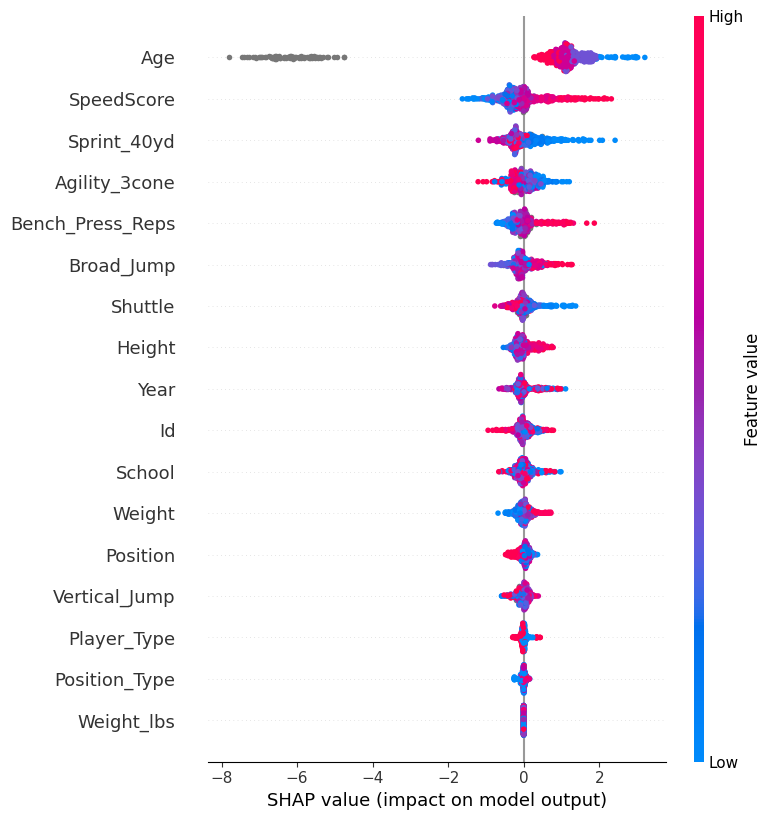

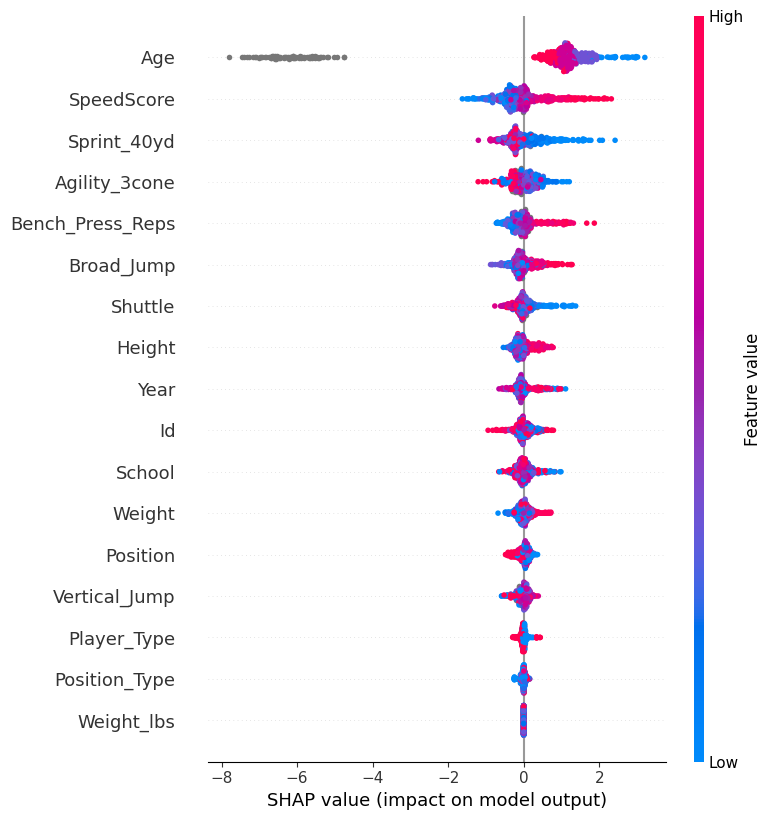

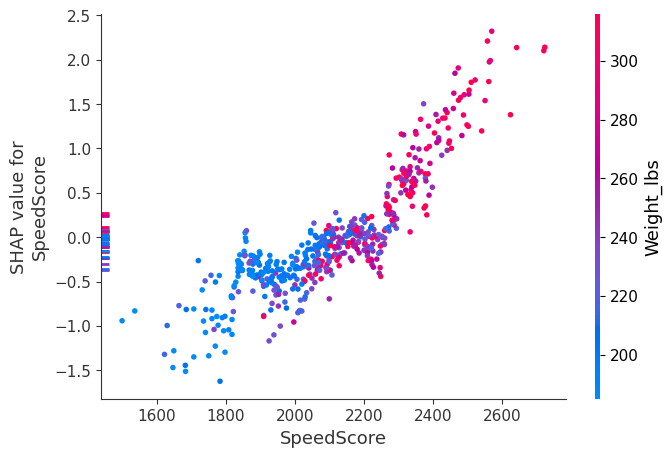

In [99]:
# ① 必要なライブラリをインポート（インストール済前提）
import shap
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# データ読み込み
PATH = "../data/"
X = pd.read_csv(PATH + "train.csv")
y = X["Drafted"]
X_features = X.drop(columns=["Drafted"])

# Label Encoding
cat_cols = ["School", "Player_Type", "Position_Type", "Position"]
le = LabelEncoder()
for col in cat_cols:
    X_features[col] = le.fit_transform(X_features[col])

# SpeedScore 再計算・追加
X_features["Weight_lbs"] = X_features["Weight"] * 2.20462
X_features["SpeedScore"] = X_features["Weight_lbs"] * (200 / X_features["Sprint_40yd"]**2)

# 学習用・検証用に分割
X_train = X_features.sample(frac=0.8, random_state=42)
X_valid = X_features.drop(X_train.index)
y_train = y.loc[X_train.index]
y_valid = y.loc[X_valid.index]

# モデル学習
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# SHAPのExplainer作成
explainer = shap.TreeExplainer(model)

# SHAP値取得
shap_values_raw = explainer.shap_values(X_valid)

# ndarray (n_samples, ), 各要素が (n_features, ) → (n_samples, n_features) に変換
import numpy as np

shap_values = np.vstack(shap_values_raw)  # shape: (n_samples, n_features)

# 可視化
shap.summary_plot(shap_values, X_valid)


# ④ SHAPサマリープロット
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_valid)

# ⑤ Dependence Plot（SpeedScore）
shap.dependence_plot("SpeedScore", shap_values, X_valid)

# ⑥ Force Plot
shap.initjs()
i = 0  # 任意の行
shap.force_plot(explainer.expected_value, shap_values[i], X_valid.iloc[i])

